# Buy/Sell Classification of the SP500 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

### Install and import YFinance

In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 510 kB/s 
     |████████████████████████████████| 6.4 MB 12.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
import yfinance as yf

## Using SP500 data from the turn of the century to July 2022

In [4]:
df = yf.download('SPY', start="2000-01-01", end="2022-07-01")

[*********************100%***********************]  1 of 1 completed


## Creating lagging variable for the Machine learning algorithm to be able to rely on short term memory in recent abberations in the data 

*   List item
*   List item



In [5]:
#Generating variables

#pct change denotes the change in the price from open-open
# this encompases the movement in price throughout the night
df['Pct_change'] = df['Open'].pct_change()

#gain represents the daily gain/loss if negative
df['Gain'] = df['Close'] - df['Open']

#ceating a lagging variable
df['pct_change_yesterday'] = df['Pct_change'].shift(1)

df['lag_avg_close3'] = df['Close'].rolling(3).mean().shift(1)

df['lag_avg_close5'] = df['Close'].rolling(5).mean().shift(1)

df['Volume_yesterday'] = df['Volume'].shift(1)



## Constructing a lagging percentage change but with a special damping coefficient if a specific condition has been met.

### --> If there has been a history of 2 or more negative percentage return days in a lagging 3 day window, then, with the if statment below, there will be a damping coefficient multiplied into the metric in order to damp the average percentage returns so that I do not over state the average when the market is trending downward

In [6]:
df['Pct_change_lag3_damp'] = np.zeros(df.shape[0])

arr = np.array(df['Pct_change'])
window_size = 3
  
i = 0
moving_averages = []
  
# Loop through the array to consider
# every window of size 3
while i < len(arr) - window_size + 1:
    
    # Store elements from i to i+window_size
    # in list to get the current window
    window = arr[i : i + window_size]

    #if there is  equal to or more than 2 negative movements in the past 3 days
    # insert a proportion to take down the expectations
    if (np.sum(window <= 0) >= 2):
      df['Pct_change_lag3_damp'][i+window_size-1] = (sum(window) / window_size)*1.5
    else:
  
    # Calculate the average of current window
      df['Pct_change_lag3_damp'][i+window_size-1] = (sum(window) / window_size)
      
    # Shift window to right by one position
    i += 1
  

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Adj Close,Volume,Pct_change,Gain,pct_change_yesterday,lag_avg_close3,lag_avg_close5,Volume_yesterday,Pct_change_lag3_damp
Date,,,,,,,,,,,,,
2000-01-03,148.25000,148.25000,143.875000,145.4375,96.139778,8164300,NaN,-2.81250,NaN,NaN,NaN,NaN,0.000000
2000-01-04,143.53125,144.06250,139.640625,139.7500,92.380135,8089800,-0.031830,-3.78125,NaN,NaN,NaN,8164300.0,0.000000
2000-01-05,139.93750,141.53125,137.250000,140.0000,92.545326,12177900,-0.025038,0.06250,-0.031830,NaN,NaN,8089800.0,NaN
2000-01-06,139.62500,141.50000,137.750000,137.7500,91.058060,6227200,-0.002233,-1.87500,-0.025038,141.729167,NaN,12177900.0,-0.029550
2000-01-07,140.31250,145.75000,140.062500,145.7500,96.346375,8066500,0.004924,5.43750,-0.002233,139.166667,NaN,6227200.0,-0.011174


In [7]:
#drop nans
df = df.dropna()

#display the data frame with the new generated metrics
df.head()

,Open,High,Low,Close,Adj Close,Volume,Pct_change,Gain,pct_change_yesterday,lag_avg_close3,lag_avg_close5,Volume_yesterday,Pct_change_lag3_damp
Date,,,,,,,,,,,,,
2000-01-10,146.25000,146.90625,145.03125,146.25000,96.676857,5741700,0.042316,0.00000,0.004924,141.166667,141.7375,8066500.0,0.015002
2000-01-11,145.81250,146.09375,143.50000,144.50000,95.520035,7503700,-0.002991,-1.31250,0.042316,143.250000,141.9000,5741700.0,0.014750
2000-01-12,144.59375,144.59375,142.87500,143.06250,94.569862,6907700,-0.008358,-1.53125,-0.002991,145.500000,142.8500,7503700.0,0.015483
2000-01-13,144.46875,145.75000,143.28125,145.00000,95.850540,5158300,-0.000864,0.53125,-0.008358,144.604167,143.4625,6907700.0,-0.006107
2000-01-14,146.53125,147.46875,145.96875,146.96875,97.151970,7437300,0.014276,0.43750,-0.000864,144.187500,144.9125,5158300.0,0.002527


## Displaying the lagging vaiables over the given time of the data

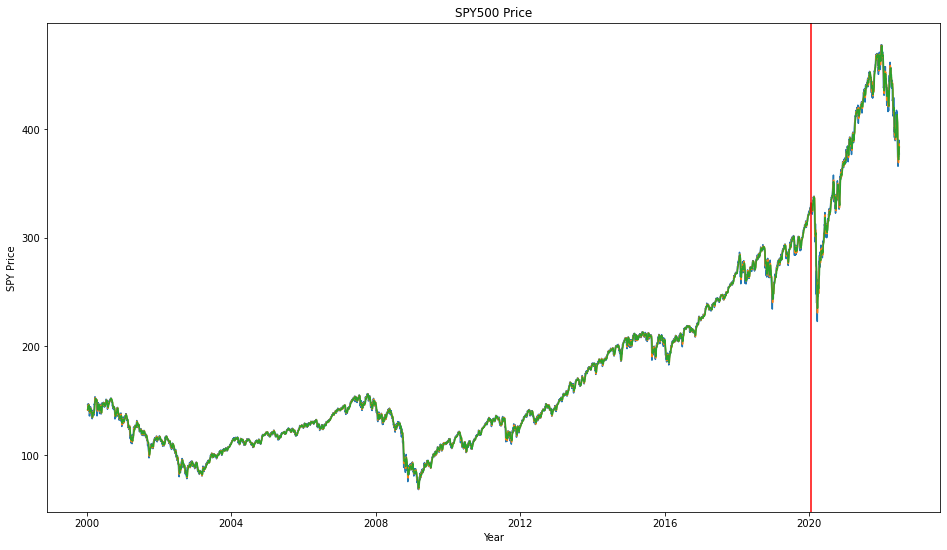

In [8]:
#Plotting the SP500 over the given time period...
# the red line signifies the beggining of covid in the USA
# this is how I have decided to split the train and test regions
plt.figure(figsize=(16,9))
plt.plot(df['Close'])
plt.plot(df['lag_avg_close3'])
plt.plot(df['lag_avg_close5'])
plt.ylabel('SPY Price')
plt.xlabel('Year')
plt.title('SPY500 Price')
plt.axvline(pd.Timestamp('2020-01-21'), color = 'r')
plt.show()

## Showing the lagging variables up close with a zoomed in set of time around the pandemic... the overstatment during the times where the market is trending down was the imputus behind the "Pct_change_lag3_damp" variable

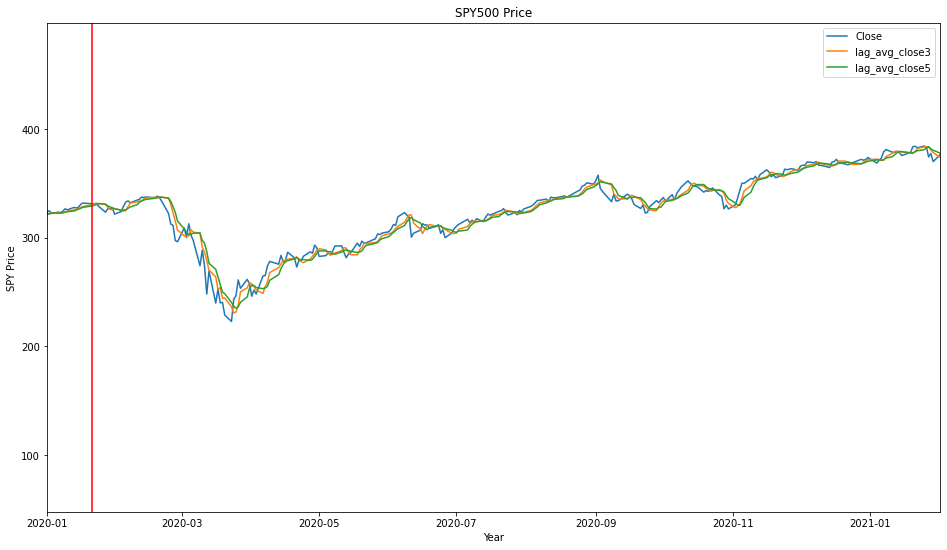

In [9]:
plt.figure(figsize=(16,9))
plt.plot(df['Close'])
plt.plot(df['lag_avg_close3'])
plt.plot(df['lag_avg_close5'])
plt.ylabel('SPY Price')
plt.xlabel('Year')
plt.title('SPY500 Price')
plt.axvline(pd.Timestamp('2020-01-21'), color = 'r')
plt.xlim([dt.date(2020,1,1), dt.date(2021, 2, 
              1)])
plt.legend(['Close','lag_avg_close3','lag_avg_close5'])
plt.show()

## You can see the orange line, the damped variable, overshoots in the negative direction which will help our algorithm make decisions with more risk adverse metrics.

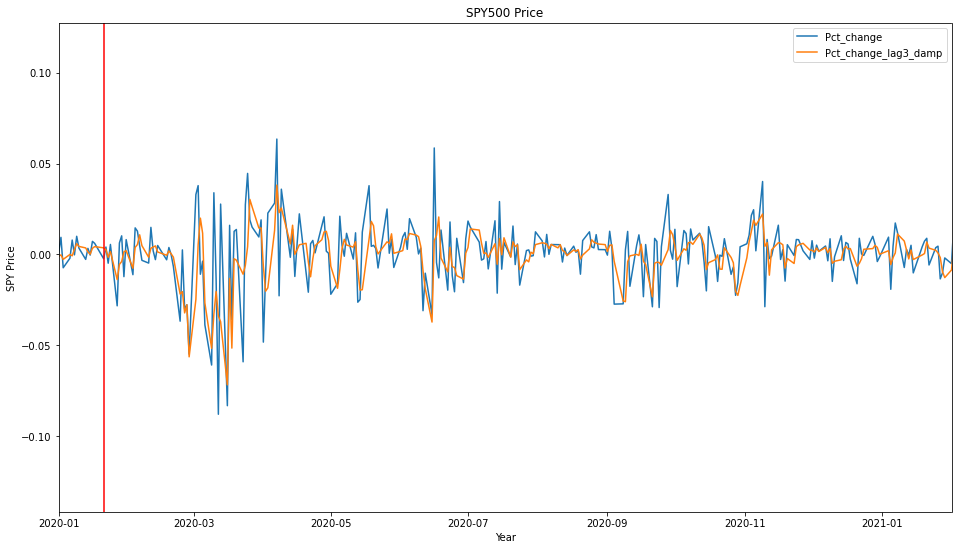

In [10]:
plt.figure(figsize=(16,9))
plt.plot(df['Pct_change'])
plt.plot(df['Pct_change_lag3_damp'])
plt.ylabel('SPY Price')
plt.xlabel('Year')
plt.title('SPY500 Price')
plt.axvline(pd.Timestamp('2020-01-21'), color = 'r')
plt.xlim([dt.date(2020,1,1), dt.date(2021, 2, 
              1)])
plt.legend(['Pct_change','Pct_change_lag3_damp' ])
plt.show()

## Gradient Boost Regression to forecast

## Making an array of binaries for the y vairable of our training and test data.

1: if the value goes up close[i-1] --> close[i]

-1: if the value goes down close[i-1] --> close[i]

In [11]:
Y = np.where(df['Close'].shift(-1) > df['Close'],1,-1)
#checking to make sure the number of rows for x and y are the same
len(Y) == df.shape[0]

True

In [12]:
#Constructing the test and train data
n_rows = df.shape[0]
p_train = 0.70

Y_train = Y[:int(np.round(n_rows*p_train))]
Y_test = Y[int(np.round(n_rows*p_train)):]

X_train = df[[ 'Volume_yesterday', 'Pct_change_lag3_damp', 'lag_avg_close3', 'lag_avg_close5', 'pct_change_yesterday']].iloc[:int(np.round(n_rows*p_train))]
X_test = df[[ 'Volume_yesterday', 'Pct_change_lag3_damp', 'lag_avg_close3', 'lag_avg_close5', 'pct_change_yesterday']].iloc[int(np.round(n_rows*p_train)):]

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [14]:
clf = GradientBoostingClassifier(n_estimators=5, learning_rate=1,
                                 max_depth=1, random_state=10, min_weight_fraction_leaf = 0.1).fit(X_train, Y_train)
clf.score(X_test, Y_test)

0.5521508544490277

### In this case the clasifier is correct more than half of the time! 55% acuracy with the optimal params as determined below. 

In [15]:
pred_array = clf.predict(X_test)

#Is the algorithm just taking a long position 
# How often is it preferencing Buy over Sell?
print(len(pred_array) == sum(pred_array), len(pred_array) ,sum(pred_array)
)

False 1697 1647


### The classifier recomends buying/holding much more frequently than it recomends selling.

In [16]:
# set params for gradient boost
params = {
    "n_estimators": [5,10],
    "max_depth": [1,2],
    #"min_samples_split": [1,2,5],
    "learning_rate": np.linspace(0.01,0.1, 3),
    "min_weight_fraction_leaf" : np.linspace(0.1,0.5,10)
    #"loss": 'huber',
    #"loss": 'squared_error', # 50% acc, 9 MSE
    #"criterion" : 'friedman_mse',
    #"verbose" : 1
}

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
gbc = GradientBoostingClassifier()
cv = GridSearchCV(gbc, params, cv=5)
cv.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': array([0.01 , 0.055, 0.1  ]),
                         'max_depth': [1, 2],
                         'min_weight_fraction_leaf': array([0.1       , 0.14444444, 0.18888889, 0.23333333, 0.27777778,
       0.32222222, 0.36666667, 0.41111111, 0.45555556, 0.5       ]),
                         'n_estimators': [5, 10]})

In [17]:
print(cv.best_params_)

{'learning_rate': 0.01, 'max_depth': 1, 'min_weight_fraction_leaf': 0.1, 'n_estimators': 5}


array([0.82093193, 0.17906807, 0.        , 0.        , 0.        ])

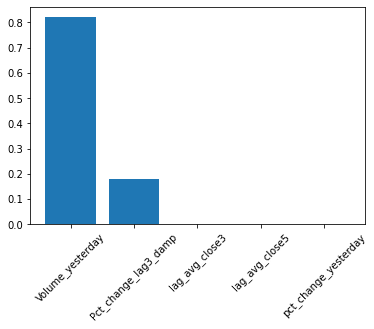

In [18]:
plt.bar(x = [ 'Volume_yesterday', 'Pct_change_lag3_damp', 'lag_avg_close3', 'lag_avg_close5', 'pct_change_yesterday'],
        height = clf.feature_importances_)
plt.xticks(rotation = 45)
clf.feature_importances_

## Using cross validation grid search to reveal the best parameters for the algorithm. After considering these parameters, it appears as if the most important metrics used to classify are those shown above on the bar chart.

In [19]:
dfa = yf.download('TSLA', start="2005-01-01", end="2022-07-01")

[*********************100%***********************]  1 of 1 completed


## Lets see how the trained classifier performs on TSLA!

In [20]:
#Generating variables

#pct change denotes the change in the price from open-open
# this encompases the movement in price throughout the night
dfa['Pct_change'] = dfa['Open'].pct_change()

#gain represents the daily gain/loss if negative
dfa['Gain'] = dfa['Close'] - dfa['Open']

#ceating a lagging variable
dfa['pct_change_yesterday'] = dfa['Pct_change'].shift(1)

dfa['lag_avg_close3'] = dfa['Close'].rolling(3).mean().shift(1)

dfa['lag_avg_close5'] = dfa['Close'].rolling(5).mean().shift(1)

dfa['Volume_yesterday'] = dfa['Volume'].shift(1)



In [21]:
dfa['Pct_change_lag3_damp'] = np.zeros(dfa.shape[0])

arr = np.array(dfa['Pct_change'])
window_size = 3
  
i = 0
moving_averages = []
  
# Loop through the array to consider
# every window of size 3
while i < len(arr) - window_size + 1:
    
    # Store elements from i to i+window_size
    # in list to get the current window
    window = arr[i : i + window_size]

    #if there is  equal to or more than 2 negative movements in the past 3 days
    # insert a proportion to take down the expectations
    if (np.sum(window <= 0) >= 2):
      dfa['Pct_change_lag3_damp'][i+window_size-1] = (sum(window) / window_size)*1.5
    else:
  
    # Calculate the average of current window
      dfa['Pct_change_lag3_damp'][i+window_size-1] = (sum(window) / window_size)
      
    # Shift window to right by one position
    i += 1
  


dfa = dfa.dropna()
dfa.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Adj Close,Volume,Pct_change,Gain,pct_change_yesterday,lag_avg_close3,lag_avg_close5,Volume_yesterday,Pct_change_lag3_damp
Date,,,,,,,,,,,,,
2010-07-07,3.280,3.326,2.996,3.160,3.160,34608500,-0.180000,-0.120,-0.130435,3.818000,4.1996,34334500.0,-0.195217
2010-07-08,3.228,3.504,3.114,3.492,3.492,38557000,-0.015854,0.264,-0.180000,3.407333,3.8760,34608500.0,-0.163144
2010-07-09,3.516,3.580,3.310,3.480,3.480,20253000,0.089219,-0.036,-0.015854,3.291333,3.6212,38557000.0,-0.053317
2010-07-12,3.590,3.614,3.400,3.410,3.410,11012500,0.021047,-0.180,0.089219,3.377333,3.4388,20253000.0,0.031471
2010-07-13,3.478,3.728,3.380,3.628,3.628,13400500,-0.031198,0.150,0.021047,3.460667,3.3528,11012500.0,0.026356


In [22]:
dfa = dfa.reset_index()

In [23]:
Ya = np.where(dfa['Close'].shift(-1) > dfa['Close'],1,-1)


n_rows = dfa.shape[0]
p_train = 0.70

Ya_train = Ya[:int(np.round(n_rows*p_train))]
Ya_test = Ya[int(np.round(n_rows*p_train)):]

Xa_train = dfa[[ 'Volume_yesterday', 'Pct_change_lag3_damp', 'lag_avg_close3', 'lag_avg_close5', 'pct_change_yesterday']].iloc[:int(np.round(n_rows*p_train))]
Xa_test = dfa[[ 'Volume_yesterday', 'Pct_change_lag3_damp', 'lag_avg_close3', 'lag_avg_close5', 'pct_change_yesterday']].iloc[int(np.round(n_rows*p_train)):]

In [24]:
Xa_test

,Volume_yesterday,Pct_change_lag3_damp,lag_avg_close3,lag_avg_close5,pct_change_yesterday
2113,21013000.0,-0.024057,67.434001,68.771600,-0.050142
2114,39960500.0,-0.015900,67.334666,68.439200,-0.027965
2115,31791500.0,0.011937,67.716665,68.057199,0.046308
2116,20638000.0,0.022232,69.185997,68.072398,0.017468
2117,15403500.0,0.001829,68.863998,68.191599,0.002919
...,...,...,...,...,...
3013,34734200.0,0.018918,708.193339,682.832007,0.014513
3014,31866500.0,0.020925,716.863342,702.396008,-0.001835
3015,29726100.0,0.014340,725.696676,719.292004,0.050098
3016,30130400.0,-0.013340,723.289998,716.668005,-0.019583


In [25]:
clf.score(Xa_test, Ya_test)

0.5447513812154696

In [26]:
pred_arraya = clf.predict(Xa_test)

len(pred_arraya) == sum(pred_arraya)

print(len(pred_arraya) == sum(pred_arraya), len(pred_arraya) ,sum(pred_arraya)
)

False 905 395


In [27]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


MPL = MLPClassifier(solver='lbfgs',hidden_layer_sizes=(8,8,8),max_iter=1000, activation='tanh', random_state=42).fit(X_train, Y_train)
MPL.predict_proba(X_test[:1])
MPL.predict(X_test)
MPL.score(X_test, Y_test)

0.5492044784914555

## Accuracy is well over 50% which, in most cases, is indicative of a "winning" algorithm